In [10]:
import pandas as pd
import numpy as np 

In [59]:
df = pd.read_json('data/tweetBizPer.json')

In [60]:
df

,date,tweet,retweet_count,fav_count,tweetBiz
0,2020-08-02,"Nosecone closing is recommended, but not requi...",67,2339,0
1,2020-08-02,When space travel becomes as common as air tra...,23761,212331,0
2,2020-08-02,Space is the new air,1026,14007,0
3,2020-08-02,Congratulations @SpaceX &amp; @NASA on complet...,18489,204600,1
4,2020-08-02,Dragon is stable in the water,16478,261192,1
...,...,...,...,...,...
10514,2011-12-03,That was a total non sequitur btw,4,7,0
10515,2011-12-03,"Great Voltaire quote, arguably better than Twa...",25,29,1
10516,2011-12-01,I made the volume on the Model S http://ow.ly/...,8,23,1
10517,2011-12-01,Went to Iceland on Sat to ride bumper cars on ...,18,165,0


In [61]:
df.isnull().sum()

date               0
tweet            110
retweet_count      0
fav_count          0
tweetBiz           0
dtype: int64

In [62]:
df.tweetBiz.unique()

array([0, 1, '1', '0', '`'], dtype=object)

In [19]:
df['tweet'].replace('None', '')

0        Nosecone closing is recommended, but not requi...
1        When space travel becomes as common as air tra...
2                                     Space is the new air
3        Congratulations @SpaceX &amp; @NASA on complet...
4                            Dragon is stable in the water
                               ...                        
10514                    That was a total non sequitur btw
10515    Great Voltaire quote, arguably better than Twa...
10516    I made the volume on the Model S http://ow.ly/...
10517    Went to Iceland on Sat to ride bumper cars on ...
10518    Please ignore prior tweets, as that was someon...
Name: tweet, Length: 10519, dtype: object

In [66]:
df.tweetBiz = df.tweetBiz.replace('`', 1)
df.tweetBiz = df.tweetBiz.replace('1', 1)
df.tweetBiz = df.tweetBiz.replace('0', 0)

In [67]:
df = df.dropna()

In [68]:
df = df.iloc[18:,:]

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
random_state = 777

In [72]:
import nltk
from bs4 import BeautifulSoup
import re
import warnings
warnings.filterwarnings("ignore")

In [73]:
#Text Preprocessing 
#remove webpage 
#can't remove @ or # as he might be mentioning or hashtaging Tesla or a news agency 
#lowercase
#remove punctuations- create a list of common punctuations 
#need to keep numbers - since we are dealing with stocks 
#use stopwords 
#keep emojis
#tokenize
#can't remove shortwords since car model names 
#https://www.ranks.nl/stopwords
#remove English stopwords 
stopwords = ['a','about','above','after', 'again', 'against','all', 'am', 'an', 'and', 'any', 'are', 'aren\'t', 'as',
             'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'can\'t', 'cannot',
             'could', 'couln\'t', 'did', 'didn\'t', 'did', 'didn\'t', 'do', 'does', 'does\'t', 'doing', 'don\'t',
             'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn\'t', 'has', 'hasn\'t', 'have',
             'haven\'t', 'having', 'he', 'he\'d', 'he\'ll', 'he\'s', 'her', 'here', 'here\'s', 'hers', 'herself',
             'him', 'himself', 'his', 'how', 'how\'s', 'i', 'i\'d', 'i\'ll', 'i\'m', 'i\'ve', 'if', 'in', 'into',
             'is', 'isn\'t', 'it', 'it\'s', 'its', 'itself', 'let\'s', 'me', 'more' 'most', 'mustn\'t', 'my', 'myself',
             'no', 'nor', 'not', 'of', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves',
             'out', 'over', 'own', 'same', 'shan\'t', 'she', 'she\'d', 'she\'ll', 'she\'s', 'should', 'shouldn\'t',
             'so', 'some', 'such', 'than', 'that', 'that\'s', 'the', 'their', 'theirs', 'them', 'themselves', 'then',
             'there', 'there\'s', 'these', 'they', 'they\'d', 'they\'ll', 'they\'re', 'they\'ve', 'this', 'those',
             'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'wasn\'t', 'we', 'we\'d', 'we\'ll',
             'we\'re', 'we\'ve', 'were', 'weren\'t', 'what', 'what\'s', 'when', 'when\'s', 'where', 'where\'s',
             'which', 'while', 'who', 'who\'s', 'whom', 'why', 'why\'s', ' with', 'won\'t', 'wouldn\'t', 'you',
             'you\'d', 'you\'ll', 'you\'re', 'you\'ve', 'your', 'yours', 'yourself', 'yourselves']

#remove punctuation from tweets 
punc = lambda x: re.sub("!|,|\?|\'|-|\"|&|。|\)|\(|！|，|\.*|/|\[|\]|\u2026|\d|:|~|、|？|☆|’|– |【|】|「|」|《|》|※| “|”|＊|→||[\b\.\b]{3}||@||@ |#|# |", '',x)



def clean_tweet(tweet):
    #remove stopwords
    #use beautiful soup to remove the &/amps etc in tweets as well as website links 
    soup_ = BeautifulSoup(tweet, 'lxml')
    soup_ = soup_.get_text()
    soup_ = re.sub(r'https?://[A-Za-z0-9./]+', '', soup_) 
 
    #lowercase the words and remove punctuation
    lower_ = ''.join([word.lower() for word in soup_])

    #remove puncutations using a custom list
    punc_ = ''.join([punc(word) for word in lower_])
    #tokenize
    token_ = re.split('\W+',punc_)
    #remove stopwords
    stop_ = [word for word in token_ if word not in stopwords]
    tweet = ' '.join(word for word in stop_)

    return tweet



In [74]:
df['cleanTweet'] = df['tweet'].apply(clean_tweet)

In [75]:
#Get rid of blank tweets removed from cleaning 
df = df[df['cleanTweet'] != '']

In [76]:
df = df.reset_index(drop = True)

In [77]:
#TFIDF vectorizer 
tfidf = TfidfVectorizer()

#Column Transformer to avoid Data Leakage 
ct = make_column_transformer(
    (tfidf, 'cleanTweet'),
    remainder='passthrough')

In [78]:
count_vect = CountVectorizer()

#CV column transformer

ct2 = make_column_transformer(
    (count_vect, 'cleanTweet'),
    remainder = 'passthrough')

In [79]:
df.head()

,date,tweet,retweet_count,fav_count,tweetBiz,cleanTweet
0,2020-07-31,The Great Pyramid was the tallest structure ma...,2390,45513,0,great pyramid tallest structure made by humans...
1,2020-07-31,So true,111,6567,0,true
2,2020-07-31,Ramses II was 😎,2946,80540,0,ramses ii
3,2020-07-31,Aliens built the pyramids obv,70731,543749,0,aliens built pyramids obv
4,2020-07-31,Ancient Egypt had an incredible esthetic that ...,289,7999,0,ancient egypt incredible esthetic stands day


In [80]:
df['tweetBiz'] = df['tweetBiz'].astype('category').cat.codes

In [81]:
df.to_json('data/elonsTweetsV7.json')

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.3)
rcParams['figure.figsize'] = 12,8

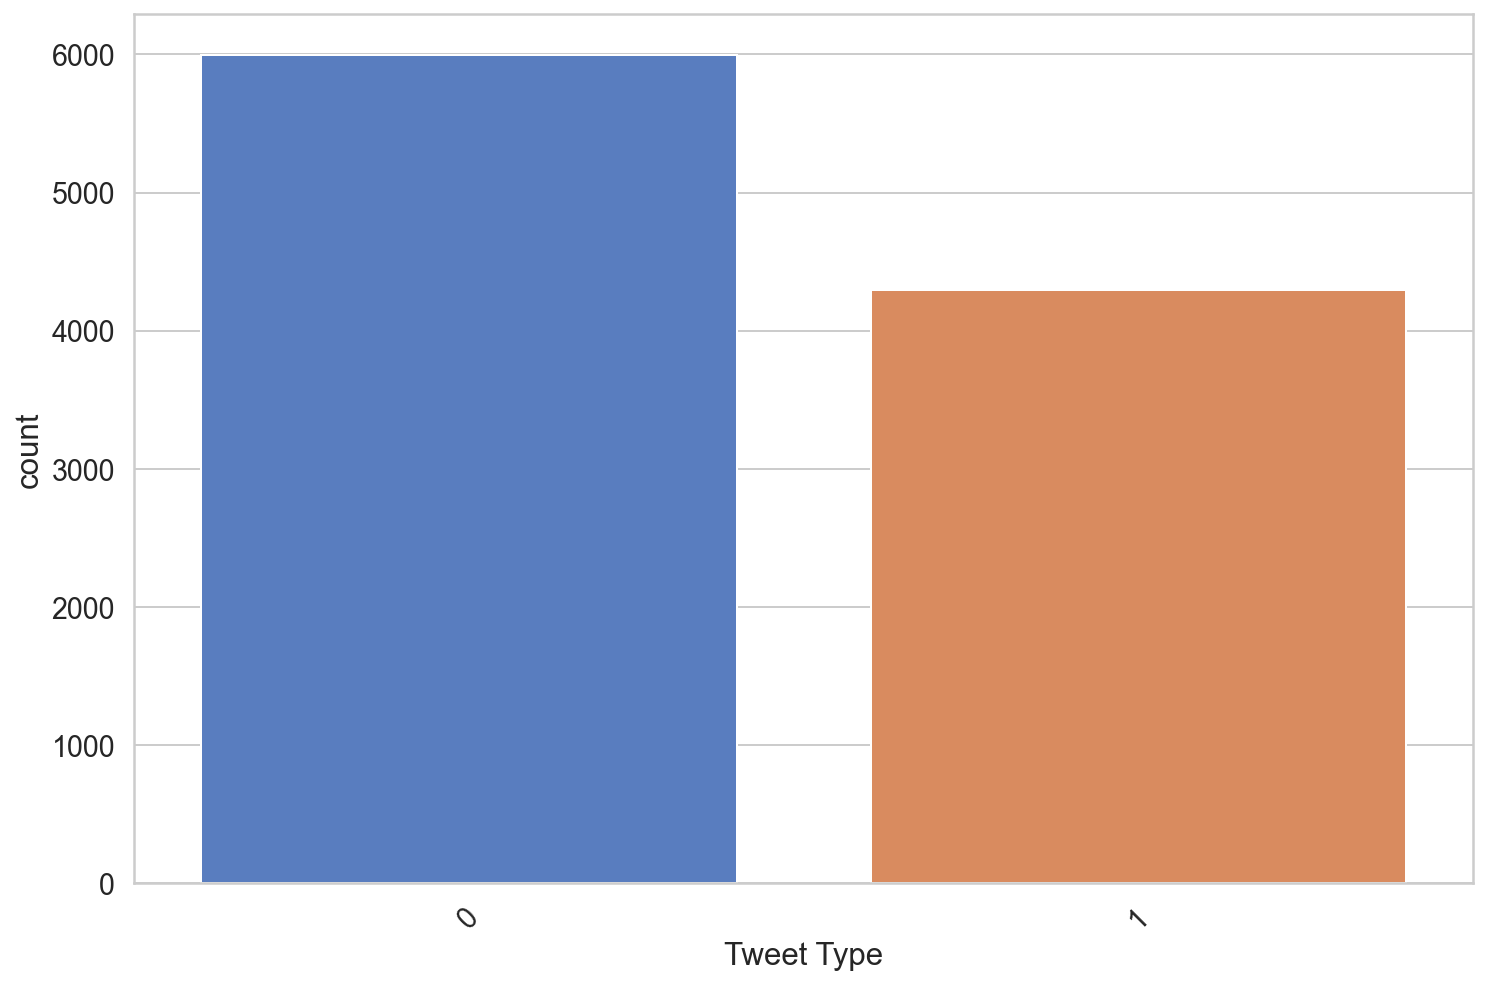

In [83]:
sns.countplot(df.tweetBiz);
plt.xlabel('Tweet Type')
plt.xticks(rotation = 45);

In [85]:
X = df[['cleanTweet']]
y = df[['tweetBiz']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = random_state)

In [86]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8234, 1), (2059, 1), (8234, 1), (2059, 1))

In [87]:
#Algos
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Metrics
from sklearn.metrics import classification_report

In [ ]:
#####Suppor Vector Machines#######

In [88]:
svc = SVC()
model1 = make_pipeline(ct, svc)
model1.fit(X_train,y_train);

In [89]:
targetName = ['Personal', 'Business']

In [90]:
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.59      1.00      0.75      1224
    Business       0.00      0.00      0.00       835

    accuracy                           0.59      2059
   macro avg       0.30      0.50      0.37      2059
weighted avg       0.35      0.59      0.44      2059



In [91]:
svc = SVC()
model1c = make_pipeline(ct2, svc)
model1c.fit(X_train,y_train);

In [92]:
y_pred1c = model1c.predict(X_test)
print(classification_report(y_test, y_pred1c, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.59      1.00      0.75      1224
    Business       0.00      0.00      0.00       835

    accuracy                           0.59      2059
   macro avg       0.30      0.50      0.37      2059
weighted avg       0.35      0.59      0.44      2059



In [93]:
##### Multinomial Naive Bayes#######

In [94]:
mb = MultinomialNB()
model2 = make_pipeline(ct, mb)
model2.fit(X_train,y_train);

In [95]:
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.61      0.83      0.71      1224
    Business       0.49      0.23      0.31       835

    accuracy                           0.59      2059
   macro avg       0.55      0.53      0.51      2059
weighted avg       0.56      0.59      0.55      2059



In [96]:
mb = MultinomialNB()
model2c = make_pipeline(ct2, mb)
model2c.fit(X_train,y_train);

In [97]:
y_pred2c = model2c.predict(X_test)
print(classification_report(y_test, y_pred2c, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.64      0.71      0.67      1224
    Business       0.49      0.40      0.44       835

    accuracy                           0.59      2059
   macro avg       0.56      0.56      0.56      2059
weighted avg       0.58      0.59      0.58      2059



In [98]:
###### Logistic Regression #######

In [99]:
lr = LogisticRegression()
model3 = make_pipeline(ct, lr)
model3.fit(X_train,y_train);

In [100]:
y_pred3 = model3.predict(X_test)
print(classification_report(y_test, y_pred3, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.62      0.79      0.69      1224
    Business       0.48      0.28      0.35       835

    accuracy                           0.58      2059
   macro avg       0.55      0.53      0.52      2059
weighted avg       0.56      0.58      0.55      2059



In [101]:
lr = LogisticRegression()
model3c = make_pipeline(ct2, lr)
model3c.fit(X_train,y_train);

In [102]:
y_pred3c = model3c.predict(X_test)
print(classification_report(y_test, y_pred3c, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.61      0.72      0.66      1224
    Business       0.45      0.34      0.38       835

    accuracy                           0.57      2059
   macro avg       0.53      0.53      0.52      2059
weighted avg       0.55      0.57      0.55      2059



In [103]:
####### Random Forest Classifier ######

In [104]:
#Create the models 
rf = RandomForestClassifier()
model4 = make_pipeline(ct, rf)
model4.fit(X_train, y_train);

In [105]:
y_pred4 = model4.predict(X_test)
print(classification_report(y_test, y_pred4, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.61      0.77      0.68      1224
    Business       0.46      0.28      0.35       835

    accuracy                           0.57      2059
   macro avg       0.53      0.53      0.51      2059
weighted avg       0.55      0.57      0.55      2059



In [106]:
rf = RandomForestClassifier()
model4c = make_pipeline(ct2, rf)
model4c.fit(X_train, y_train);

In [107]:
y_pred4c = model4c.predict(X_test)
print(classification_report(y_test, y_pred4c, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.61      0.70      0.65      1224
    Business       0.43      0.33      0.37       835

    accuracy                           0.55      2059
   macro avg       0.52      0.52      0.51      2059
weighted avg       0.54      0.55      0.54      2059



In [108]:
##### XGBoost Classifier #########

In [109]:
xgb = XGBClassifier()
model5 = make_pipeline(ct, xgb)
model5.fit(X_train, y_train);

In [110]:
y_pred5 = model5.predict(X_test)
print(classification_report(y_test, y_pred5, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.62      0.82      0.71      1224
    Business       0.49      0.25      0.33       835

    accuracy                           0.59      2059
   macro avg       0.56      0.54      0.52      2059
weighted avg       0.57      0.59      0.55      2059



In [111]:
xgb = XGBClassifier()
model5c = make_pipeline(ct2, xgb)
model5c.fit(X_train, y_train);

In [112]:
y_pred5c = model5c.predict(X_test)
print(classification_report(y_test, y_pred5c, target_names=targetName))

              precision    recall  f1-score   support

    Personal       0.62      0.84      0.71      1224
    Business       0.49      0.23      0.32       835

    accuracy                           0.59      2059
   macro avg       0.55      0.54      0.51      2059
weighted avg       0.57      0.59      0.55      2059



In [113]:
#Multinomial Bayes Hyperparameter tuning 

In [114]:
model2c.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'multinomialnb', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__countvectorizer', 'columntransformer__countvectorizer__analyzer', 'columntransformer__countvectorizer__binary', 'columntransformer__countvectorizer__decode_error', 'columntransformer__countvectorizer__dtype', 'columntransformer__countvectorizer__encoding', 'columntransformer__countvectorizer__input', 'columntransformer__countvectorizer__lowercase', 'columntransformer__countvectorizer__max_df', 'columntransformer__countvectorizer__max_features', 'columntransformer__countvectorizer__min_df', 'columntransformer__countvectorizer__ngram_range', 'columntransformer__countvectorizer__preprocessor', 'columntransformer__countvectorizer__stop_words', 'columntransformer__countvectorizer__strip_acc

In [115]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [116]:
#Set parameters for randomforest to tune 
params = {}

params['columntransformer__countvectorizer__max_features'] = np.arange(1000,11000, 1000)
params['columntransformer__countvectorizer__ngram_range'] = [(1,3), (1,2), (1,1),(2,2), (3,3)]
params['multinomialnb__alpha'] = [0.1, 0.5, 1, 2, 5, 10]

In [117]:
clf = RandomizedSearchCV(model2c, params, random_state=random_state)

In [118]:
clf.fit(X_train,y_train);

In [119]:
clf.best_params_

{'multinomialnb__alpha': 0.5,
 'columntransformer__countvectorizer__ngram_range': (2, 2),
 'columntransformer__countvectorizer__max_features': 1000}

In [120]:
#Looking at the best model results 
results = pd.DataFrame(clf.cv_results_)
results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multinomialnb__alpha,param_columntransformer__countvectorizer__ngram_range,param_columntransformer__countvectorizer__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.125668,0.003112,0.034915,0.000164,0.5,"(2, 2)",1000,"{'multinomialnb__alpha': 0.5, 'columntransform...",0.596140,0.588921,0.586735,0.590600,0.004019,1
9,0.130346,0.004824,0.035687,0.000889,1,"(2, 2)",4000,"{'multinomialnb__alpha': 1, 'columntransformer...",0.592134,0.592566,0.578717,0.587807,0.006428,2
5,0.125098,0.009824,0.033508,0.000372,5,"(2, 2)",6000,"{'multinomialnb__alpha': 5, 'columntransformer...",0.583030,0.588192,0.583090,0.584770,0.002419,3
7,0.058885,0.001640,0.023623,0.001609,10,"(1, 1)",2000,"{'multinomialnb__alpha': 10, 'columntransforme...",0.589949,0.571793,0.587099,0.582949,0.007972,4
3,0.285736,0.008562,0.060014,0.002840,5,"(1, 3)",6000,"{'multinomialnb__alpha': 5, 'columntransformer...",0.585579,0.576531,0.586006,0.582706,0.004369,5


In [121]:
#The best score 
clf.best_score_

0.5905999514209376

In [123]:
df.to_json('data/tweetdataV7.json')